In [2]:
from PIL import Image
import numpy as np
import os
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

# Data loading

This cell contains code for loading image data from a dataset. The `load_data` function reads metadata from an Excel file and iterates over folders and images to load them into numpy arrays. The progress is displayed using the `tqdm` progress bar.


In [2]:

def load_data(metadata_path, data_directory, num_folders=6):
    # Read metadata from the Excel file
    metadata = pd.read_excel(metadata_path)
    
    # Lists to store images and corresponding labels
    images = []
    labels = []
    
    # Count total images in the dataset directory
    total_images = sum(1 for _ in Path(data_directory).rglob('*.png'))
    
    # Define finger folders for both left and right hands
    finger_folders = ["l_index", "l_little", "l_middle", "l_ring", "l_thumb", 
                      "r_index", "r_little", "r_middle", "r_ring", "r_thumb"]
    
    # Initialize and display a progress bar
    progress_bar = tqdm(total=total_images, desc='Loading images', dynamic_ncols=True)
    
    # Iterate over metadata rows (limited by num_folders)
    for index, row in metadata.iterrows():
        if index >= num_folders:
            break
            
        # Iterate over finger folders
        for finger_folder in finger_folders:
            # Create the path for the current finger folder
            folder_path = Path(data_directory) / str(row['id']) / finger_folder
            
            # Check if the folder exists
            if folder_path.exists():
                # List all image files in the folder
                image_files = list(folder_path.glob("*.png"))
                
                # Iterate over image files
                for img_path in image_files:
                    # Open and convert the image to a numpy array
                    img = Image.open(img_path)
                    img = np.array(img)
                    
                    # Append the image to the images list
                    images.append(img)
                    
                    # Create a dictionary with image metadata for the current label
                    label = {
                        'id': row['id'],
                        'gender': row['gender'],
                        'age': row['age'],
                        'melanin': row['melanin'],
                        'cardiovascular_disease': row['cardiovascular disease'],
                        'smoker': row['smoker'],
                        'sport_hobby_with_fingers': row['sport/hobby with fingers'],
                        'alcohol_before_scan': row['alcohol before scan'],
                        'skin_disease': row['skin disease'],
                        'finger': finger_folder
                    }
                    
                    # Append the label dictionary to the labels list
                    labels.append(label)
                    
                    # Update the progress bar
                    progress_bar.update(1)
                
    # Close the progress bar after loading all images
    progress_bar.close()
    
    # Convert the images list to a numpy array and return both images and labels
    return np.array(images), labels

# You can call this function to load the data:
images, labels = load_data("data_description.xlsx", "dataset")

# save them using pickle

pickle.dump(images, open("images.pkl", "wb"))
pickle.dump(labels, open("labels.pkl", "wb"))




Loading images:  81%|████████  | 1458/1805 [02:26<00:34,  9.99it/s]


### Images preprocessing

In [6]:
import skimage

from skimage import exposure
import numpy as np

from skimage.color import rgb2gray
from skimage import io, color
from PIL import Image
import random
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# Function to preprocess a single image
def preprocess_image(image, target_size=(1024, 1024)):
    # Convert image to numpy array if not already
    img_array = np.array(image)

    # Check if the image has an alpha channel (transparency)
    if img_array.shape[-1] == 4:
        # Convert to RGB first, then grayscale
        grayscale_img = color.rgb2gray(img_array[..., :3])
    elif img_array.shape[-1] == 3:
        # Convert to grayscale
        grayscale_img = color.rgb2gray(img_array)
    else:
        # Image is already grayscale
        grayscale_img = img_array

    # Apply histogram equalization
    equalized_img = exposure.equalize_adapthist(grayscale_img, clip_limit=0.03)

    # Scale the image to range [-1, 1]
    scaled_img = (equalized_img * 2.0) - 1.0  # This scales the 0-1 range to -1 to 1

    # Convert scaled image back to a PIL image for further processing
    processed_image = Image.fromarray(np.uint8((scaled_img + 1) * 0.5 * 255), mode='L')

    original_size = processed_image.size
    ratio = min(target_size[0]/original_size[0], target_size[1]/original_size[1])
    new_size = (int(original_size[0] * ratio), int(original_size[1] * ratio))

    # Resize the image using the calculated size
    processed_image = processed_image.resize(new_size, Image.Resampling.LANCZOS)

    # Create a new image with the target size and a black background
    new_image = Image.new("L", target_size)

    # Paste the resized image onto the center of the new image
    new_image.paste(processed_image, ((target_size[0] - new_size[0]) // 2, (target_size[1] - new_size[1]) // 2))

    return new_image

def preprocess_labels(labels):
    # Assuming all dicts have the same structure
    keys = labels[0].keys()
    label_data = {key: np.array([dic[key] for dic in labels]) for key in keys}

    # Initialize encoders
    one_hot_encoder = OneHotEncoder()
    label_encoder = LabelEncoder()

    # Process categorical data
    categorical_keys = ['gender', 'smoker', 'sport_hobby_with_fingers', 'alcohol_before_scan', 'skin_disease', 'finger']
    categorical_data = np.stack([label_data[key] for key in categorical_keys], axis=1)
    categorical_data_encoded = one_hot_encoder.fit_transform(categorical_data).toarray()

    # Process numerical/ordinal data
    numerical_keys = ['age']
    numerical_data = np.stack([label_data[key] for key in numerical_keys], axis=1)

    # Process data that may require custom encoding like 'melanin', 'cardiovascular_disease'
    # For example, melanin might be encoded based on the count of 'L' and 'R' occurrences, or any domain-specific method
    # cardiovascular_disease might be one-hot encoded if it has standard categories, or label-encoded if it's more like a ranking

    # For now, we'll just use the age directly and ignore other complex features for simplicity
    condition_input = np.concatenate([numerical_data, categorical_data_encoded], axis=1)

    return condition_input


### Testing preprocessing

In [8]:
# test preprocessing with one image 
processed_image = preprocess_image(images[0])
# # Display the preprocessed first image
plt.imshow(processed_image, cmap='gray')
plt.axis('off')
plt.title('Enhanced Image')
plt.show()

AttributeError: module 'PIL.Image' has no attribute 'Resampling'

### Loading and preprocessing images

In [1]:
import pickle 
import concurrent.futures


# load data from pickle files
images = pickle.load(open("images.pkl", "rb"))
labels = pickle.load(open("labels.pkl", "rb"))


preprocessed_labels = preprocess_labels(labels)
print('Labels preprocessing done')


# Assuming preprocess_image is a function that processes a single image

def preprocess_image_parallel(image):
    return preprocess_image(image)

# Create an empty list to store preprocessed images
preprocessed_images = []

# Define the preprocessing function for parallel execution
def preprocess_and_append(image):
    preprocessed_image = preprocess_image_parallel(image)
    preprocessed_images.append(preprocessed_image)

# Use ThreadPoolExecutor for parallel processing
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    # Submit the preprocessing tasks
    futures = [executor.submit(preprocess_and_append, image) for image in images]
    
    # Display a progress bar using tqdm
    for _ in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc='Preprocessing Images', dynamic_ncols=True):
        pass

# Convert the list of preprocessed images to a numpy array
preprocessed_images = np.stack(preprocessed_images, axis=0)


# save preprocessed data to pickle files

with open('preprocessed_images.pickle', 'wb') as f:
    pickle.dump(preprocessed_images, f)
    
    
with open('preprocessed_labels.pickle', 'wb') as f:
    pickle.dump(preprocessed_labels, f)

NameError: name 'preprocess_labels' is not defined

# Architecture Description: Conditional GAN (cGAN) in Keras

This code defines a Conditional Generative Adversarial Network (cGAN) architecture using Keras. A cGAN is a type of GAN that conditions the generation process on additional input information, allowing for controlled image synthesis.

## Generator:
- The generator takes noise (`z_dim`-dimensional latent vector) and a conditional input as inputs.
- It uses a fully connected layer to combine noise and condition, followed by batch normalization for stabilization.
- The generator then applies up-sampling layers to reach the desired image size.
- The final layer produces an image with `tanh` activation.

## Discriminator:
- The discriminator takes an image and a conditional input as inputs.
- It combines the image and condition through concatenation, expanding the condition to match the image size.
- Convolutional layers process the combined input to discriminate between real and generated images.
- The discriminator outputs a single value (logit) without using a sigmoid activation, as it will be used with a suitable loss function.

## Usage:
- The generator and discriminator are initialized using their respective classes: `Generator` and `Discriminator`.
- The generator takes noise and condition as input and outputs a generated image.
- The discriminator takes an image and condition as input and outputs a discrimination score.

Note: This architecture is designed for conditional image generation, where the generation process is influenced by additional information (condition) beyond just random noise.


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator
class Generator():
    
    def __init__(self, z_dim, condition_shape, img_shape):
        # z_dim: Dimension of the latent space (noise vector)
        # condition_shape: Shape of the condition input (e.g., parameters like age, blood pressure)
        # img_shape: Shape of the generated image output

        self.z_dim = z_dim
        self.condition_shape = condition_shape
        self.img_shape = img_shape

        self.model = self.build_generator()

    def build_generator(self):
        # Noise input (z_dim-dimensional latent vector)
        z_input = layers.Input(shape=(self.z_dim,))
        # Conditional input (additional information you want to condition the generation on)
        condition_input = layers.Input(shape=(self.condition_shape,))
        
        # Combine noise and condition via concatenation
        x = layers.Concatenate()([z_input, condition_input])
        
        # Fully connected layer that takes the combined input
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)  # Helps to stabilize training
        
        # Up-sampling: Increasing the dimensionality to get to the correct image size
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)  # Further stabilization of training
        # The final layer has a size of the product of the image dimensions (width * height * channels)
        x = layers.Dense(np.prod(self.img_shape), activation='tanh')(x)  # 'tanh' activation is common for GANs
        # Reshape the output to the size of the image
        img = layers.Reshape(self.img_shape)(x)
        
        # The generator model takes noise and condition as input and outputs an image
        generator = models.Model([z_input, condition_input], img, name='generator')

        return generator
    
class Discriminator():
    
    def __init__(self, img_shape, condition_shape):
        # img_shape: Shape of the input image
        # condition_shape: Shape of the condition input

        self.img_shape = img_shape
        self.condition_shape = condition_shape

        self.model = self.build_discriminator()

    def build_discriminator(self):
        # Image input (shape of the input image)
        img_input = layers.Input(shape=self.img_shape)
        # Conditional input (shape of the condition)
        condition_input = layers.Input(shape=self.condition_shape)

        # Combine image and condition via concatenation
        # We assume that condition input is a flat vector and needs to be expanded to the image size
        condition_input_expanded = layers.Dense(np.prod(self.img_shape))(condition_input)
        condition_input_expanded = layers.Reshape(self.img_shape)(condition_input_expanded)
        combined_input = layers.Concatenate()([img_input, condition_input_expanded])

        # Convolutional layers
        x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(combined_input)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.3)(x)

        # Flatten and add a dense layer
        x = layers.Flatten()(x)
        x = layers.Dense(1)(x)  # Not using sigmoid activation because it will be used in combination with a loss function that expects logits

        # Create the discriminator model
        discriminator = models.Model([img_input, condition_input], x, name='discriminator')

        return discriminator




2023-11-16 21:09:40.659513: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 21:09:41.626787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load preprocessed files 

- We can use previously defined preprocessor to load images from saved binary files.

In [6]:
import pickle
import numpy as np
with open('preprocessed_images.pickle', 'rb') as f:
    preprocessed_images = pickle.load(f)

with open('preprocessed_labels.pickle', 'rb') as f:
    preprocessed_labels = pickle.load(f)
    
    

# Saving one image to a text file
# np.savetxt("image.txt", preprocessed_images[0], newline=" ")    



### Undersampling (optional)
- For training purposes, we can undersample the dataset to reduce the training time. This is optional, but recommended for initial testing.


In [7]:
SAMPLE_LIMIT = 1000

preprocessed_images = preprocessed_images[0:SAMPLE_LIMIT]
preprocessed_labels = preprocessed_labels[0:SAMPLE_LIMIT]

z_dim = 100  # This should match the z_dim you used to initialize your Generator
batch_size = preprocessed_images.shape[0]  # Or any other batch size you want to use
noise = np.random.normal(0, 1, (batch_size, z_dim))



### Synthetic Image Generation testing

The provided code snippet demonstrates the generation and visualization of synthetic images using a pre-trained generator.

#### Generator Initialization:
- The `Generator` class is used to initialize a generator model.
- The `z_dim` represents the dimension of the latent space (noise vector).
- The second parameter specifies the shape of the conditional input (preprocessed labels).
- The third parameter defines the shape of the generated image (`(1024, 1024, 1)` in this case).

#### Generating Synthetic Images:
- The generator's `predict` method is used to generate synthetic images based on noise and preprocessed labels.
- The `noise` is a random input to the generator, and `preprocessed_labels` provides additional conditioning information.

#### Image Scaling:
- The synthetic images are scaled from values between 0 and 1 to values between 0 and 255.
- This scaling is done to convert the images into a format suitable for visualization and further processing.

#### Visualization:
- The code then visualizes eight small synthetic images in a 4x2 grid using Matplotlib.
- Each subplot in the grid displays one synthetic image, reshaped to a 1024x1024 grayscale image.
- The `cmap='gray'` argument specifies the grayscale color map.

Note: The quality and diversity of the generated images depend on the training of the generator model and the quality of the input noise and labe


2023-11-16 21:09:55.687260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 21:09:55.879917: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-16 21:09:55.937013: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2147483648 exceeds 10% of free system memory.
2023-11-16 21:09:56.242262: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2147483648 exceeds 10% of free

4/4 [==============================] - 1s 184ms/step
100


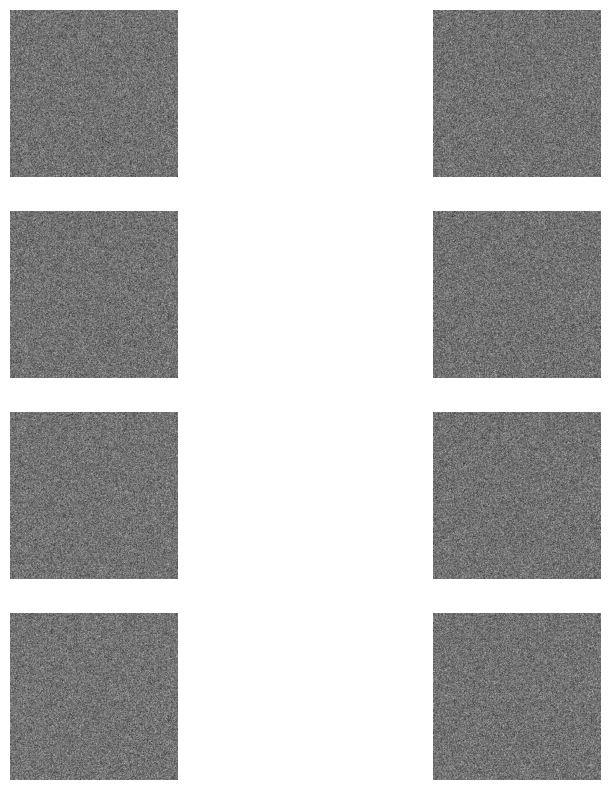

In [8]:
# Initialize the generator with appropriate parameters
generator = Generator(z_dim, preprocessed_labels.shape[1], (1024, 1024, 1))

# Generate synthetic images using the generator model
synthetic_images = generator.model.predict([noise, preprocessed_labels])

# Scale the numpy array from values between 0 and 1 to values between 0 and 255
synthetic_images = (synthetic_images * 255).astype(np.uint8)

# Print the number of generated synthetic images
print("Number of Synthetic Images:", len(synthetic_images))

# Plot eight small synthetic images in a 4x2 grid
fig, axes = plt.subplots(4, 2, figsize=(10, 10))
axes = axes.flatten()

# Iterate over synthetic images and corresponding subplots
for img, ax in zip(synthetic_images, axes):
    # Reshape the image and display it in grayscale
    # add label: uninitialized images
    ax.imshow(img.reshape(1024, 1024), cmap='gray')
    ax.axis('off')
    plt.tight_layout()
    plt.show()


### Standalone generator training
- Since generator takes much longer to train than discriminator, we can train it separately from the rest of the GAN.

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt

# Set the number of iterations over each image
iterations = 10

# Define the optimizer and loss function for the generator
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
mse_loss = MeanSquaredError()

# Compile the generator model
generator.model.compile(optimizer=generator_optimizer, loss=mse_loss)

# Training loop
for epoch in range(iterations):
    for i in range(len(preprocessed_images)):
        real_image = preprocessed_images[i:i+1]  # Select a single image slice
        label = preprocessed_labels[i:i+1]       # Select the corresponding label slice

        # Generate noise
        noise = np.random.normal(0, 1, (1, z_dim))
        
        # Generate a synthetic image
        synthetic_image = generator.model.predict([noise, label])
        
        # Scale the synthetic image to match the real image range
        synthetic_image = (synthetic_image + 1) / 2
        
        # Compute the loss between the synthetic and real image
        loss = generator.model.train_on_batch([noise, label], real_image)
        
        # Print the loss
        print(f'Epoch: {epoch}, Loss: {loss}')

# Display a synthetic image
        plt.imshow(synthetic_image[0].reshape(1024, 1024), cmap='gray')
        plt.axis('off')
        plt.show()
        input()

1/1 [==============================] - 0s 142ms/step
Epoch: 0, Loss: 13080.31640625
1/1 [==============================] - 0s 124ms/step
Epoch: 0, Loss: 13309.0771484375
1/1 [==============================] - 0s 143ms/step
Epoch: 0, Loss: 13080.244140625
1/1 [==============================] - 0s 167ms/step
Epoch: 0, Loss: 13080.208984375
1/1 [==============================] - 0s 241ms/step
Epoch: 0, Loss: 13216.634765625
1/1 [==============================] - 0s 133ms/step
Epoch: 0, Loss: 13308.9296875
1/1 [==============================] - 0s 162ms/step
Epoch: 0, Loss: 13308.888671875
1/1 [==============================] - 0s 144ms/step
Epoch: 0, Loss: 13080.048828125
1/1 [==============================] - 0s 129ms/step
Epoch: 0, Loss: 13308.79296875
1/1 [==============================] - 0s 177ms/step
Epoch: 0, Loss: 13334.361328125
1/1 [==============================] - 0s 188ms/step
Epoch: 0, Loss: 13030.6298828125
1/1 [==============================] - 0s 132ms/step
Epoch: 0, Loss

### Discriminator testing 


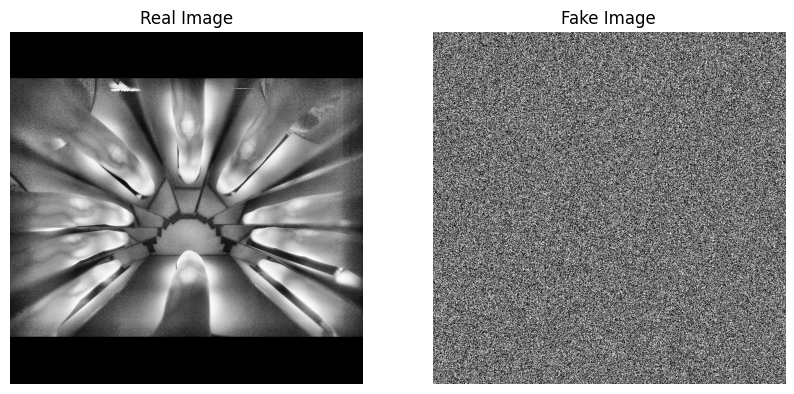

4/4 [==============================] - 4s 932ms/step
tf.Tensor(
[[9.9989265e-01]
 [1.0000000e+00]
 [9.7016352e-01]
 [2.7782863e-01]
 [1.7880310e-01]
 [1.0000000e+00]
 [9.9999708e-01]
 [9.9999964e-01]
 [7.4740565e-01]
 [9.9988669e-01]
 [9.9999273e-01]
 [9.9999976e-01]
 [2.6358452e-01]
 [9.9999440e-01]
 [9.1912371e-01]
 [9.7770429e-01]
 [6.0436118e-01]
 [9.5000178e-01]
 [9.9899524e-01]
 [9.9965793e-01]
 [1.8194932e-01]
 [9.9959838e-01]
 [9.9954146e-01]
 [9.2578650e-01]
 [9.9995029e-01]
 [5.0179612e-02]
 [7.2446001e-01]
 [9.9713153e-01]
 [9.9996227e-01]
 [9.9967569e-01]
 [9.9997717e-01]
 [1.0000000e+00]
 [9.8658228e-01]
 [9.9903822e-01]
 [9.9958718e-01]
 [9.9982190e-01]
 [9.8444712e-01]
 [2.6414034e-01]
 [9.9996406e-01]
 [7.3571962e-01]
 [8.5308284e-01]
 [9.9591166e-01]
 [7.2275716e-01]
 [9.9998873e-01]
 [9.9466270e-01]
 [9.9988657e-01]
 [9.9999976e-01]
 [7.9045397e-01]
 [1.2959489e-03]
 [1.0000000e+00]
 [9.3928909e-01]
 [2.4107285e-03]
 [9.9596506e-01]
 [6.2993813e-01]
 [4.3493010e-02]
 

In [8]:
PRELOAD_GENERATOR = False

# Initialize the discriminator (make sure the img_shape matches the generator output)
discriminator = Discriminator(img_shape=(1024, 1024, 1), condition_shape=preprocessed_labels.shape[1])
generator = Generator(z_dim, preprocessed_labels.shape[1], (1024, 1024, 1))

if PRELOAD_GENERATOR:
    # Load the generator weights
    generator.model.load_weights('generator.h5')

 
# Prepare labels for real images (1s) and fake images (0s)
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

real_images = preprocessed_images.astype(np.float32)
fake_images = synthetic_images.astype(np.float32)

# print real and fake image in one plot
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(real_images[0].reshape(1024, 1024), cmap='gray')
axes[0].axis('off')
axes[0].set_title('Real Image')
axes[1].imshow(fake_images[0].reshape(1024, 1024), cmap='gray')
axes[1].axis('off')
axes[1].set_title('Fake Image')
plt.show()


# Get discriminator predictions for fake images
fake_predictions = discriminator.model.predict([synthetic_images, preprocessed_labels])

# Get discriminator predictions for real images
real_predictions = discriminator.model.predict([real_images, preprocessed_labels])

# The predictions are logits; to interpret them as probabilities, you can use the sigmoid function
fake_probabilities = tf.sigmoid(fake_predictions)
real_probabilities = tf.sigmoid(real_predictions)

# print the probabilities

print(fake_probabilities)
print(real_probabilities)

### cGAN model

In [9]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
import numpy as np

# Assume Generator and Discriminator classes are already defined as per previous discussion

def build_cgan(generator, discriminator, z_dim, condition_shape):
    # Make sure only the generator is trainable
    discriminator.model.trainable = False
    generator.model.trainable = True

    # Inputs to the combined model
    z = layers.Input(shape=(z_dim,))
    condition = layers.Input(shape=(condition_shape,))
    
    # Generate an image based on noise and condition inputs
    img = generator.model([z, condition])
    
    # The discriminator takes the generated image as input and gives a probability
    valid = discriminator.model([img, condition])

    # The combined model (stacked generator and discriminator)
    cgan_model = models.Model([z, condition], valid, name='cgan')

    # Compile the combined model
    cgan_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    return cgan_model

# Initialize the generator and discriminator
z_dim = 100
condition_shape = preprocessed_labels.shape[1]  
img_shape = (1024, 1024, 1)  # Example image shape, adjust as per your data
generator = Generator(z_dim, condition_shape, img_shape)
discriminator = Discriminator(img_shape, condition_shape)

# Build the cGAN model
cgan = build_cgan(generator, discriminator, z_dim, condition_shape)

# Now cgan is a model that, when trained, will update the generator's weights
# to try to "fool" the discriminator, while the discriminator's weights remain fixed


In [1]:
import numpy as np


# Compile the discriminator and cGAN models
discriminator.model.compile(optimizer=Adam(0.002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
cgan.compile(optimizer=Adam(0.002, 0.5), loss='binary_crossentropy')


print("CGAN and Discriminator compiled")

epochs = 10  # Number of epochs to train for
batch_size = 2  # Size of the batch

# Convert labels to float32 for consistency
preprocessed_labels = preprocessed_labels.astype(np.float32)

# Get the number of batches per epoch
num_batches = int(preprocessed_images.shape[0] / batch_size)


idx = np.random.randint(0, preprocessed_images.shape[0], batch_size)
labels = preprocessed_labels[idx]

# Generate a batch of fake images
noise = np.random.normal(0, 1, (batch_size, z_dim))
gen_imgs = generator.model.predict([noise, labels])

# plot images 
gen_imgs = (gen_imgs * 255).astype(np.uint8)

plt.imshow(gen_imgs[0], cmap='gray')
plt.show()

# print generator weights 
generator.model.summary()

# update weights of generator
generator.model.trainable = True


for epoch in range(epochs):
    for batch in range(num_batches):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Get a batch of real images
        idx = np.random.randint(0, preprocessed_images.shape[0], batch_size)
        real_imgs = preprocessed_images[idx]
        labels = preprocessed_labels[idx]

        # Generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.model.predict([noise, labels])

        # Labels for real and fake data
        valid_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.model.train_on_batch([real_imgs, labels], valid_y)
        d_loss_fake = discriminator.model.train_on_batch([gen_imgs, labels], fake_y)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # We want the generator to trick the discriminator, so we label the generated images as real
        g_loss = cgan.train_on_batch([noise, labels], valid_y)

        # If at the end of the epoch, save models, print out stats, or adjust learning rates if necessary
        print(f"{epoch}/{epochs} [D loss: {d_loss[0]}, acc: {100*d_loss[1]}] [G loss: {g_loss}]")
        
    # generate and plot image to test generator
    noise = np.random.normal(0, 1, (1, z_dim))
    label = preprocessed_labels[0:1]
    gen_img = generator.model.predict([noise, label])
    gen_img = (gen_img * 255).astype(np.uint8)
    plt.imshow(gen_img[0], cmap='gray')
    plt.show()
    

# After training is complete, save your models
generator.model.save('generator_model.h5')
discriminator.model.save('discriminator_model.h5')

NameError: name 'discriminator' is not defined

In [ ]:
# load generator and discriminator 
from tensorflow.keras.models import load_model
generator = load_model('generator_model.h5')
discriminator = load_model('discriminator_model.h5')


# load lables 
with open('preprocessed_labels.pickle', 'rb') as f:
    preprocessed_labels = pickle.load(f)
    
    
    
# generate images for all labels
z_dim = 100  # This should match the z_dim you used to initialize your Generator
batch_size = preprocessed_labels.shape[0]  # Or any other batch size you want to use
noise = np.random.normal(0, 1, (batch_size, z_dim))
synthetic_images = generator.model.predict([noise, preprocessed_labels])
